In [3]:
import tiktoken
from datasets import load_dataset
import torch
import os
import pickle
import random
random.seed(1330) 

ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])
# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
vocab_size = enc.n_vocab

KeyboardInterrupt: 

In [2]:
len(enc.encode(haikutext))

879434

In [3]:
data = torch.tensor(enc.encode(haikutext), dtype=torch.long)

#train test split
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [2]:
# hyperparameters
torch.mps.empty_cache()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 16 # how many independent sequences will we process in parallel (reduced due to memory allocation)
block_size = 256 # what is the maximum context length for predictions
max_iters = 10000 # epochs/learning iterations
eval_interval = 10 # for printing loss updates
checkpoint_interval = 50 #save checkpoint
learning_rate = 3e-4 # Slower learning rate for wide model and to avoid more sudden spikes
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
n_block_layers = 6
dropout = 0.2

NameError: name 'torch' is not defined

In [6]:
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel


#Relearning Epoch starting point
iterationStart = 0


#Stopping criteria parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0


util_tools = ut(train_data, val_data, block_size, batch_size, device)
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)

if os.path.exists(f'.lossesTikToken/trainlosses_{iterationStart}.pkl'):
    with open(f'.lossesTikToken/trainlosses_{iterationStart}.pkl', "rb") as file:
        trainlosses = pickle.load(file)
else:
    trainlosses = []

if os.path.exists(f'.lossesTikToken/vallosses_{iterationStart}.pkl'):
    with open(f'.lossesTikToken/vallosses_{iterationStart}.pkl', "rb") as file:
        vallosses = pickle.load(file)
else:
    vallosses = []


if os.path.exists(f'./model_weightsTikToken/model_weights_{iterationStart}.pth'):
    print("Loading from previous checkpoint", f"'./model_weightsTikToken/model_weights_{iterationStart}.pth'")
    # Load previous weights
    model.load_state_dict(torch.load(f'./model_weightsTikToken/model_weights_{iterationStart}.pth', weights_only=True))

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = util_tools.estimate_loss(model, eval_iters)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trainlosses.append(losses['train'])
        vallosses.append(losses['val'])

        #Stopping Criteria
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping")
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            break
    if iter % checkpoint_interval ==0 and iter >0:
        # Save the weights checkpoint
        torch.save(model.state_dict(), f"./model_weightsTikToken/model_weights_{iter+iterationStart}.pth")

    # sample a batch of data
    xb, yb = util_tools.get_batch(split ='train')
    xb, yb = xb.to(device), yb.to(device)


    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print("Train complete")
# Save the weights
torch.save(model.state_dict(), f"./model_weightsTikToken/model_weights_{iter+iterationStart}.pth")
with open(f"./lossesTikToken/trainlosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(trainlosses, file)
with open(f"./lossesTikToken/vallosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(vallosses, file)

82.532021 M parameters
step 0: train loss 11.6083, val loss 11.6033
step 10: train loss 8.6459, val loss 8.4788
step 20: train loss 7.2657, val loss 7.1841
step 30: train loss 6.5169, val loss 6.5793
step 40: train loss 6.2245, val loss 6.3465
step 50: train loss 6.0953, val loss 6.2575
step 60: train loss 5.9985, val loss 6.1935
step 70: train loss 5.9064, val loss 6.1063
step 80: train loss 5.8409, val loss 6.0413
step 90: train loss 5.7884, val loss 5.9696
step 100: train loss 5.7243, val loss 5.8947
step 110: train loss 5.6716, val loss 5.8200
step 120: train loss 5.6252, val loss 5.7861
step 130: train loss 5.5785, val loss 5.7213
step 140: train loss 5.5318, val loss 5.7236
step 150: train loss 5.4973, val loss 5.6510
step 160: train loss 5.4724, val loss 5.6220
step 170: train loss 5.4333, val loss 5.5896
step 180: train loss 5.4021, val loss 5.5675
step 190: train loss 5.3768, val loss 5.5330
step 200: train loss 5.3427, val loss 5.4795
step 210: train loss 5.3189, val loss 5.4

: 

: 

In [7]:
# Save the weights
torch.save(model.state_dict(), f"./model_weightsTikToken/model_weights_{max_iters+iterationStart}.pth")
with open(f"./lossesTikToken/trainlosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(trainlosses, file)
with open(f"./lossesTikToken/vallosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(vallosses, file)

# Losses


In [11]:
def load_pkl_file(file_path):
    with open(file_path, 'rb') as file:
        return list(pickle.load(file))
    
trainlossfile = sorted([item for item in os.listdir('./lossesTikToken') if 'train' in item])
vallossfile = sorted([item for item in os.listdir('./lossesTikToken') if 'val' in item])
traininglosses = []
vallosses = []
for i in range(0, len(trainlossfile)):
    traininglosses.extend(load_pkl_file(f'./lossesTikToken/{trainlossfile[i]}'))
    vallosses.extend(load_pkl_file(f'./lossesTikToken/{vallossfile[i]}'))

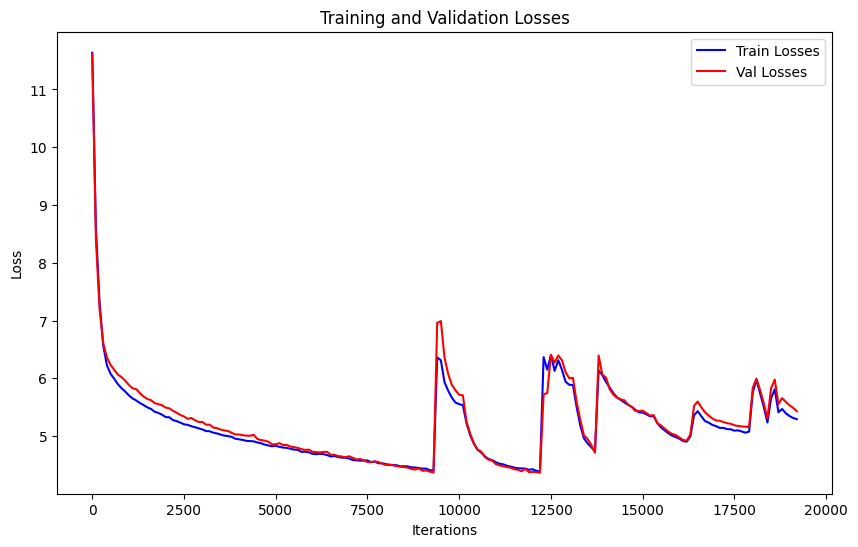

In [12]:
import matplotlib.pyplot as plt
# Create the plot
x_values = list(range(0,len(traininglosses)*100,100))
plt.figure(figsize=(10, 6))

# Plot the training losses
plt.plot(x_values, traininglosses, label='Train Losses', color='blue')
# Plot the validation losses
plt.plot(x_values, vallosses, label='Val Losses', color='red')
# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
# Add a legend
plt.legend()
# Show the plot
plt.show()